# 2013 Influence Data Analysis to Prototyping

Initial analysis of the available data.

In [1]:
from matplotlib import pyplot as plt
from IPython.display import display

import folium
import geopandas as gpd
import pandas as pd

In [2]:
%matplotlib inline

In [3]:
br_chart = gpd.GeoDataFrame.from_file('../prototype/static/data/br-states.json')

/home/xmn/anaconda3/envs/fludashboard/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


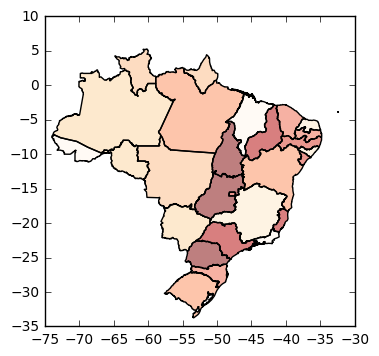

In [4]:
br_chart.plot(colormap='OrRd')
plt.show()

In [5]:
df_incidence = pd.read_csv('../data/clean_data_filtro_sintomas_dtsin4mem-incidence-2013.csv')
df_typical = pd.read_csv('../data/mem-typical-2016-uf.csv')
df_thresholds = pd.read_csv('../data/mem-report-2016-uf.csv')
df_pop = pd.read_csv('../data/populacao_uf_regional_atual.csv')

In [6]:
# prepare dataframe keys
for _df in [df_incidence, df_typical, df_thresholds, df_pop]:
    for k in _df.keys():
        _df.rename(columns={
            k: k.replace(' ', '_').replace('-', '_')
        }, inplace=True)

UF  isoweek  SRAG2013
0  11        1       0.0
1  11        2       0.0
2  11        3       0.0
3  11        4       0.0
4  11        5       0.0

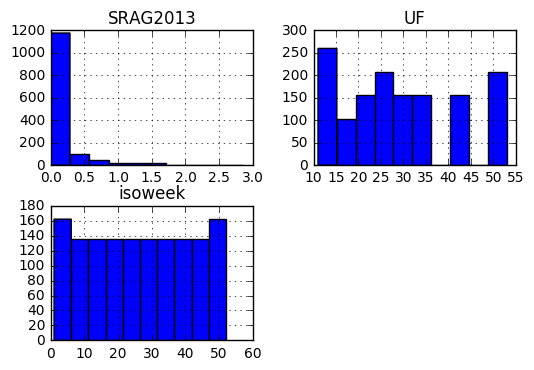

In [7]:
display(df_incidence.head())

df_incidence.hist()
plt.show()

UF  População  isoweek  corredor_baixo  corredor_mediano  corredor_alto  \
0  11    1768204        1             0.0          0.000000       0.000000   
1  11    1768204        2             0.0          0.000000       0.000000   
2  11    1768204        3             0.0          0.169664       0.169664   
3  11    1768204        4             0.0          0.056555       0.056555   
4  11    1768204        5             0.0          0.056555       0.056555   

  Unidade_da_Federação  
0             Rondônia  
1             Rondônia  
2             Rondônia  
3             Rondônia  
4             Rondônia

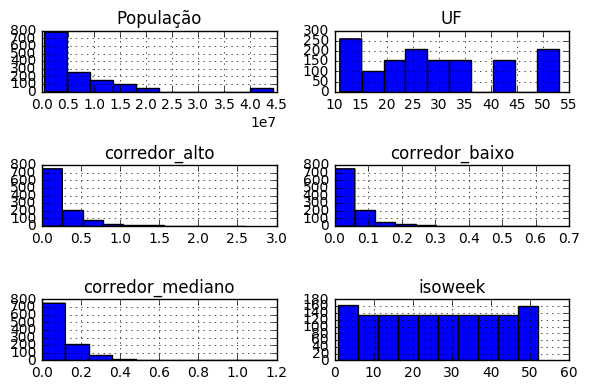

In [8]:
display(df_typical.head())

df_typical.hist()
plt.tight_layout()
plt.show()

In [9]:
df = pd.merge(
    df_incidence, df_typical, on=['UF', 'isoweek'], how='right'
).merge(
    df_thresholds.drop(['Unidade_da_Federação', 'População'], axis=1), 
    on='UF'
)
display(df.head(5))

UF  isoweek  SRAG2013  População  corredor_baixo  corredor_mediano  \
0  11        1       0.0    1768204             0.0          0.000000   
1  11        2       0.0    1768204             0.0          0.000000   
2  11        3       0.0    1768204             0.0          0.169664   
3  11        4       0.0    1768204             0.0          0.056555   
4  11        5       0.0    1768204             0.0          0.056555   

   corredor_alto Unidade_da_Federação  \
0       0.000000             Rondônia   
1       0.000000             Rondônia   
2       0.169664             Rondônia   
3       0.056555             Rondônia   
4       0.056555             Rondônia   

   Média_geométrica_do_pico_de_infecção_das_temporadas_regulares  \
0                                           0.140678               
1                                           0.140678               
2                                           0.140678               
3                                           0.140678               
4                                           0.140678               

   limiar_pré_epidêmico  intensidade_alta  intensidade_muito_alta  \
0              0.282773          0.565546                1.131091   
1              0.282773          0.565546                1.131091   
2              0.282773          0.565546                1.131091   
3              0.282773          0.565546                1.131091   
4              0.282773          0.565546                1.131091   

   se_típica_do_início_do_surto IC_da_se_típica_do_início_do_surto  \
0                          12.0                         [4.0-39.0]   
1                          12.0                         [4.0-39.0]   
2                          12.0                         [4.0-39.0]   
3                          12.0                         [4.0-39.0]   
4                          12.0                         [4.0-39.0]   

   duração_típica_do_surto IC_da_duração_típica_do_surto  
0                      2.0                     [0.0-8.0]  
1                      2.0                     [0.0-8.0]  
2                      2.0                     [0.0-8.0]  
3                      2.0                     [0.0-8.0]  
4                      2.0                     [0.0-8.0]

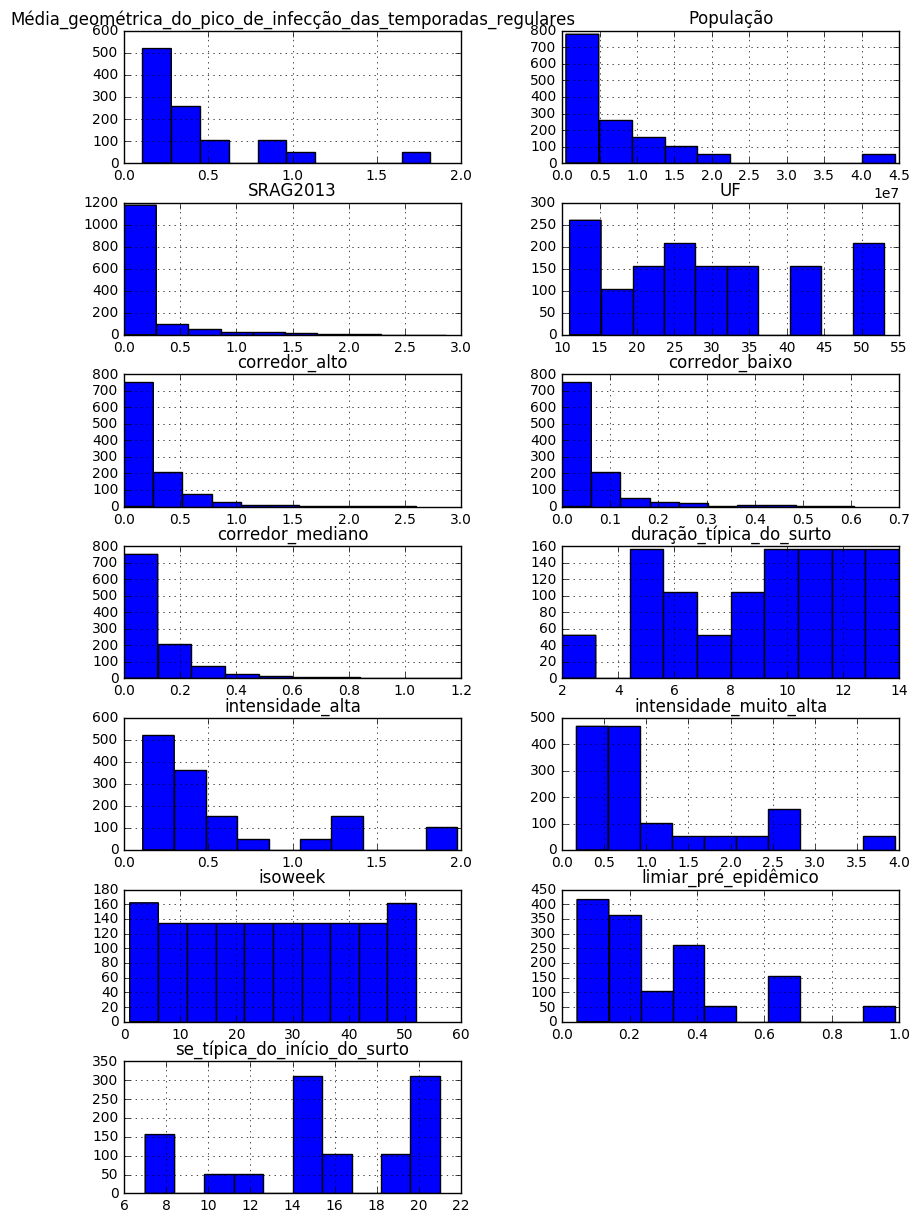

In [10]:
df.hist(layout=(7, 2), figsize=(10, 15))
# plt.tight_layout()
plt.show()

In [11]:
df_state_table = df[
    ['Unidade_da_Federação', 'UF']
].drop_duplicates().reset_index(drop=True)

df_state_table

Unidade_da_Federação  UF
0              Rondônia  11
1                  Acre  12
2              Amazonas  13
3               Roraima  14
4                  Pará  15
5                 Amapá  16
6             Tocantins  17
7              Maranhão  21
8                 Piauí  22
9                 Ceará  23
10  Rio Grande do Norte  24
11              Paraíba  25
12           Pernambuco  26
13              Alagoas  27
14              Sergipe  28
15                Bahia  29
16         Minas Gerais  31
17       Espírito Santo  32
18       Rio de Janeiro  33
19            São Paulo  35
20               Paraná  41
21       Santa Catarina  42
22    Rio Grande do Sul  43
23   Mato Grosso do Sul  50
24          Mato Grosso  51
25                Goiás  52
26     Distrito Federal  53

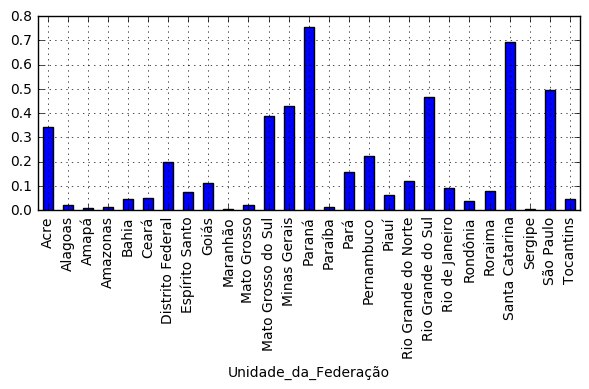

In [12]:
df_state = df.groupby(['Unidade_da_Federação'])['SRAG2013'].mean()

df_state.plot(kind='bar')
plt.tight_layout()
plt.grid(True)
plt.show()

## Time criteria

for a whole year criteria:

use the same procedure adopted by ECDC in their annual report. Which is:

* Red if the incidence was above the high threshold for at least 5 weeks;
* Orange if above the high threshold from 1 to 4 weeks;
* Yellow if crossed the epidemic threshold but not the high one;
* Green if it did not cross the epidemic threshold.

for a specific week criteria:

* Here, the levels are:
* Low: incidence < epidemic threshold
* Medium: epi. thresh. < incidence < high thresh.
* High: high thresh. < incidence < very high thresh.
* Very high: very high thresh. < incidence

So:

* low: green
* medium: yellow
* high: orange
* very high: red

In [13]:
# filter by a specific week
year = 2013
isoweek = 20

In [14]:
mask = df.eval('isoweek=={}'.format(isoweek))
df_alert = df[mask].reset_index()
df_alert = df_alert.assign(incidence = df['SRAG{}'.format(year)])

In [15]:
# * Low: incidence < epidemic threshold | green
df_alert = df_alert.assign(
    low_incidence=lambda se: se.eval('incidence < limiar_pré_epidêmico')
)

# * Medium: epi. thresh. < incidence < high thresh. | yellow
df_alert = df_alert.assign(
    medium_incidence=lambda se: se.eval(
        'limiar_pré_epidêmico <= incidence < intensidade_alta'
))

# * High: high thresh. < incidence < very high thresh. | orange
df_alert = df_alert.assign(
    high_incidence=lambda se: se.eval(
        'intensidade_alta <= incidence < intensidade_muito_alta '
))

# * Very high: very high thresh. < incidence | red
df_alert = df_alert.assign(
    very_high_incidence=lambda se: se.eval(
        'intensidade_muito_alta <= incidence'
))

df_alert[[
    'UF', 'Unidade_da_Federação',
    'low_incidence', 
    'medium_incidence',
    'high_incidence',
    'very_high_incidence'
]]

UF Unidade_da_Federação low_incidence medium_incidence high_incidence  \
0   11             Rondônia          True            False          False   
1   12                 Acre          True            False          False   
2   13             Amazonas          True            False          False   
3   14              Roraima          True            False          False   
4   15                 Pará          True            False          False   
5   16                Amapá          True            False          False   
6   17            Tocantins          True            False          False   
7   21             Maranhão          True            False          False   
8   22                Piauí         False             True          False   
9   23                Ceará         False             True          False   
10  24  Rio Grande do Norte          True            False          False   
11  25              Paraíba          True            False          False   
12  26           Pernambuco          True            False          False   
13  27              Alagoas          True            False          False   
14  28              Sergipe          True            False          False   
15  29                Bahia         False             True          False   
16  31         Minas Gerais          True            False          False   
17  32       Espírito Santo          True            False          False   
18  33       Rio de Janeiro          True            False          False   
19  35            São Paulo          True            False          False   
20  41               Paraná          True            False          False   
21  42       Santa Catarina          True            False          False   
22  43    Rio Grande do Sul          True            False          False   
23  50   Mato Grosso do Sul          True            False          False   
24  51          Mato Grosso          True            False          False   
25  52                Goiás          True            False          False   
26  53     Distrito Federal          True            False          False   

   very_high_incidence  
0                False  
1                False  
2                False  
3                False  
4                False  
5                False  
6                False  
7                False  
8                False  
9                False  
10               False  
11               False  
12               False  
13               False  
14               False  
15               False  
16               False  
17               False  
18               False  
19               False  
20               False  
21               False  
22               False  
23               False  
24               False  
25               False  
26               False

In [16]:
# alert
alert_col = df_alert.T.apply(
    lambda se: (
        '4' if se.very_high_incidence else
        '3' if se.high_incidence else
        '2' if se.medium_incidence else
        '1'
    )
)

df_alert = df_alert.assign(alert=alert_col)

display(df_alert[['UF', 'Unidade_da_Federação', 'alert']])

UF Unidade_da_Federação alert
0   11             Rondônia     1
1   12                 Acre     1
2   13             Amazonas     1
3   14              Roraima     1
4   15                 Pará     1
5   16                Amapá     1
6   17            Tocantins     1
7   21             Maranhão     1
8   22                Piauí     2
9   23                Ceará     2
10  24  Rio Grande do Norte     1
11  25              Paraíba     1
12  26           Pernambuco     1
13  27              Alagoas     1
14  28              Sergipe     1
15  29                Bahia     2
16  31         Minas Gerais     1
17  32       Espírito Santo     1
18  33       Rio de Janeiro     1
19  35            São Paulo     1
20  41               Paraná     1
21  42       Santa Catarina     1
22  43    Rio Grande do Sul     1
23  50   Mato Grosso do Sul     1
24  51          Mato Grosso     1
25  52                Goiás     1
26  53     Distrito Federal     1

In [17]:
state_geo = '../prototype/static/data/br-states.json'

width, height = 600, 350
fig = folium.element.Figure(width=width, height=height)


#Let Folium determine the scale
mapa = folium.Map(
    location=[-10, -52], zoom_start=3
)

mapa.choropleth(
    geo_path=state_geo, data=df_state,
    columns=['Unidade_da_Federação', 'alert'],
    threshold_scale=[0.5, 1.5, 2.5, 3.5, 4.5],
    key_on='feature.properties.nome',
    fill_color='YlOrRd',fill_opacity=0.7, line_opacity=0.5,
    legend_name='Rate (%)',
    reset=True
)

fig.add_children(mapa)
fig